## Report
---
This page describes choices and details results. It includes
- Description of the **model architectures** 
- Description of the **hyperparameters**
- Plot of **rewards**
- Ideas for **future works**

>Note1: for this project, I **did not need (and use) GPU** at all

>Note2: I spent around **25 hours** working on the project (not counting training time)

>Note3: As mentioned subsequently, I had **difficulties in reproducing the results** despite using the same seed.

### Description of the model architectures 
My repository is structured as follow.
- [`main_continuous_control.ipynb`](src_submission/main_continuous_control.ipynb) is **the central file you want to use**. It contains
    - all the import statements and instructions to start the environment
    - calls to `train`
    - calls to `test`
- [`ddpg_agent.py`](src_submission/ddpg_agent.py) defines three classes
    - `Agent` with methods such as `step`, `act`, `learn` 
    - `ReplayBuffer` to store experience tuples 
	- `Ornstein-Uhlenbeck Noise` process, used when calling `agent.act()` to help convergence of the Actor
- [`model.py`](src_submission/model.py) defines the Actor and Critic Networks used by the Agent
- [`checkpoint_critic36.pth`](src_submission/checkpoint_critic36.pth) and [`checkpoint_actor36pth`](src_submission/checkpoint_actor36.pth) are the saved model weights of one of my successful agents

I did not start from scratch. Instead, I use the example of **DDPG** and add changes to work with **20 agents**. I modified the code so that:
-     after each step, **each agent adds its experience to a replay buffer** that is **shared** by all agents
-     the (local) actor and critic networks are **updated each 20 times in a row** (one for each agent), using 20 different samples from the replay buffer. This update takes place after **each agent has completed 20 steps**.


This is done with:

`if len(self.memory) > BATCH_SIZE and self.step_counter % (20*NUM_AGENTS) == 0:
    for _ in range(20):
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)
`

In addition, I follow the advice in the project instructio and use gradient clipping when training the critic network. The corresponding snippet of code is as follows:

`self.critic_optimizer.zero_grad()
critic_loss.backward()
torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
self.critic_optimizer.step()`


Since the state space is relatively small (compared to 84 * 84 RGB pixels image e.g.), there is no need to implement convolutional layers. Multiple **fully-connected units** show good results.

To **improve stability** of the DDPG algorithm, I use target networks for both the critic and the policy.

The Critic network is structured as followed:
    - State (space size = 33)
    - Fully-connected layer with *128* outputs
    - *ReLu* activation function
    - Concatenation with the four actions
    - Fully-connected layer with *64* outputs
    - *ReLu* activation function
    - Fully-connected layer with *32* outputs
    - *ReLu* activation function
    - Fully-connected layer with *4* outputs (= action space size)

The Actor network is structured as followed:
    - State (space size = 33)
    - Fully-connected layer with *128* outputs
    - *ReLu* activation function
    - Fully-connected layer with *4* outputs
    - *TanH* activation function -- to output the four (= action space size)values for torque values in `[-1, 1]`

Note: the submission source does not include batch normalization, as I implemented this technique afterwards.

The Replay Memory
    - is based on *uniform sampling*

For stability, a **soft update** of the model parameters is completed.
    - `θ_target = τ*θ_local + (1 - τ)*θ_target`

This is done in the static method `soft_update(local_model, target_model, tau)` where the models to update are passed by reference.

In the same vein, I found beneficial to **clip the gradient** of the Critic in the `learn()` method with 
`torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)`

In addition, as suggested in the lecture, I decided to get **less aggressive** with the number of **updates per time step**:
    - I perform update _10 times_ every _20 steps_ instead of _20 times each episode_.

### Description of the hyperparameters


In [1]:
BUFFER_SIZE = int(5e5)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 3e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 20       # how often to update the network
NUM_AGENTS = 20
seed = 36               # used in initializing Torch models, the OUNoise and the ReplayBuffer

#### Impact of seed
The `seed` is a parameter used to **initialize the pseudorandom number generators**

This is one **important hyperparameter** I played with.

To better understand how this can impact the performance in training, I tried **40 different seeds**. 

> Note: Between each trial, I took care to reset my agent (so that learning starts from scratch each time)

The **discrepancy in outcomes** is **significant**, as shown in the figure below.

![Returns for 40 different seeds](report_submission/seed-raw.png)

Among the 40 seeds, five of them enabled to solve the environment in less than 300 episodes.

`successful_seeds = [3, 15, 25, 33, 36]`

Nevertheless, four of them failed when training a second time, as can be seen on the subsequnt figure:

![Reproducing the results on the 3 top seeds](report_submission/non-repeatable.png)

Conclusions
> Conclusion1: the **seed** has a large impact on performance. Hence it is important to **document the one used in each report**. Moreover, I found beneficial to try different seeds on the same code.

> Conclusion2: even with fix seed, model and hyperparameters, results are **not reproducible**. The only "non-controllable element" I can think of now is the *environment* itself.
Is there any way to *fix a seed for it* as well?

Decisions
> Decision1: - similar to the assemssment and hyperparameter tuning of [this benchmark](https://arxiv.org/abs/1604.06778), the algorithm is executed under **five random seeds**. With

`
seeds = [random.randint(1, 100) for _ in range(5)]
for i in seeds:
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=i)
    scores = ddpg(name=i)`

After looking at the parameter used to initialize the pseudorandom number generators, I investigate the **impact** of **additional design choise and hyper-parameters**:

#### Monitoring tools
Since most of my first trials were poorly performing (never reached score of 2), I decided to implement a couple of **monitoring tools**

- -1- Obviously, **looking at the environment** helps detecting behaviours. While this is not possible when running the code on a server, it is very easy to **early spot dysfunction**. One example of failure is given in the subsequent gif.

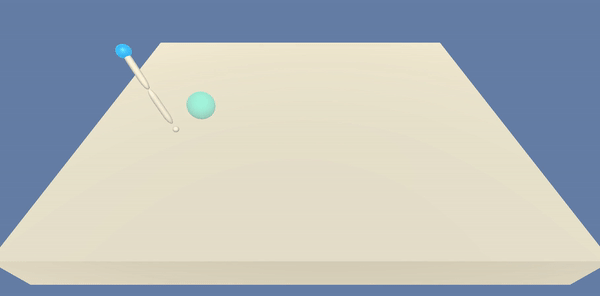

In [6]:
from IPython.display import Image
with open('report_submission/saturated-torques.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

GIF: saturation of actuator - a single failing agent constantly applying maximum torques

- -2- Furthermore, I realized that the **distribution in actions** is worth being monitored.
In particular, it is important for the **4 torques to avoid saturation**. In other words, their values should not converge to -1 or 1. I noticed that agents which failed usually get their torques staying in these extrema:

`Episode 300	Average Score: 0.01	Score: 0.00
actions batch at 210000-th learning:
	 shape = (512, 4),
	 mean = [0.9937137 0.994178  0.9852728 0.9932276],
	  std = [0.07084329 0.06561087 0.12122507 0.07632062]`

![Returns during training](report_submission/action-distribution.png)

Observations:

- It can be seen that the **successful agents** keep, on average, their actions **far away from extremums torques**.

- In addition, the **sampled batch** keeps **diversity in actions**, as depicted by the **standard deviation**.

Based on these observervations, I better understand the role of the **Ornstein-Uhlenbeck Noise**

- among other, it allows for **escaping from situations** were the Actor gets its **torques saturated** (i.e. blocked a `1` or `-1`)
- It uses **action space noise** to **change the likelihoods** associated with each action the agent might take from one moment to the next. 

#### The use of the Ornstein-Uhlenbeck process
When activated, a noise is added to each of the torque given by the Actor.
So doing, it 

- I tested my models **with** and **without** the OUnoise.
- As pointed, the results are not reproducible. For that reason, I performed **3 training for each of them**.

- Results are summurized in this table.


|OUNoise| Yes | No |
|---|---|---|
|1- #episodes to success|  451 |  430 |
|2- #episodes to success|  451 |  N.A. |
|3- #episodes to success|  451 |  430 |
  
- `N.A.` means that *2000 episodes were not enough* to solve the problem, i.e. the value of discount rate does not allow for a solution

- Conclusion: adding noise environment requires a **long-term strategy** for planning. Hence the discout rate should be high, just slightly lower than 1. Yet not exactly equal to 1 to avoid freezing issue.

Future work:
- I read that adding **parameter noise** is better than adding **action noise**: [https://arxiv.org/abs/1706.01905](https://arxiv.org/abs/1706.01905).
- In short, this makes an agent’s **exploration more consistent** across different timesteps
- I would like to see if these findings applies for the Reacher environment.

![Returns during training](https://blog.openai.com/content/images/2017/07/p_diag_1.png)

Action space noise (left), compared to parameter space noise (right)

Source: [OpenAI blog](https://blog.openai.com/better-exploration-with-parameter-noise/)

#### Depth of the Q-network
I deem appropriate to use the same architecture for the **Critic** as for **project_1**, since **observation spaces** have same size.

The **depth** of the Actor networks, i.e. the number of hidden layers, is now investigated.

- Architectures of 1, 2 and 3 FC layers are compared
    
|layers|1| 2| 3|
|---|---|---|---|
|Episodes needed|  468 |  430 | 470  |

   - Conclusion: stacking layers stops showing relevance after 2 FC layers. The **2-FC-layer** structure gives the best results. Nevertheless, I go for a **shadow structure** since it offers performance not far from the top while **limiting the complexity** and hence the **time** required.

> To achieve the best performance, the **1-FC-layer** structure is adopted for the Actor

- Compared to the `seed` parameter, the **depth of the Actor network** does not play a significant role

### Plot of Rewards

During training, every **average score** (=sum of rewards, averaged over the 20 agents) is saved. At the end, a plot shows their evolution.

![Returns during training](report_submission/success-raw.png)

Details about score calculation:

- After each episode, I add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 20 (potentially different) scores. Then take the **average of these 20 scores**.

- This yields an `average score` for each episode (where the average is over all 20 agents).

- The agent solved the problem, i.e. an the **average (over 100 episodes)** of `average scores` is at least `+30`

The subsequent figure shows the evolution of `average scores` over episodes.

![Returns during training](report_submission/success-mean.png)

### Ideas for Future Work - stabilizing the algorithm

Given that *performance* is measured with the **AVERAGE** number of episodes needed to solve the environment, regardless of the computational cost, it is important to **reduce the standard deviation** of my results, i.e. **improve robustness and repeatibility**. As mentioned, the **robustness with respect to the seed** is **very poor**. Each time, ~1 in 3 seeds succeeds. The others fail. Worse, each seed, when reused, shows a different performance. Reducing this deviation is the top priority for future works.

- I do not have solution yet. Nevertheless, it makes me think of a parallel with **Ensemble technique**. Why not automating the start with let's say 5 seeds, combine them, and stop those who do not reach a certain threshold after a given time?
- Also, I would need to further investigate how the environment is structured. Fore sure, there should be a way to fix the **initialize its pseudorandom number generators**

When playing with the **Ornstein-Uhlenbeck Noise**, I found that perturbations applied on torques of the Actor could sometimes large enough to saturate the action `-1` or `1`. It leads to the agent repeatedly executing the same action. I read about this issued. As mentioned in the OpenAI blog:

- **picking the right scale of noise** is **difficult**

- The sensitivity may **change over time** while training progresses

As a result, I would like to try to **reduce the noise** applied over time. Like the **reduction in exploration** implemented in DQN with a **epsilon-scheduling**

Other ideas:
- Consider the **time** as a evaluation metric as well. Especially since it takes me a while to train each time five an algorithm on five different seeds.
- I have not tried working with a single agent. It would be interesting to see if the same algorithm shows more robustness than the 20-agent version.

- I am implementing a PER (**Prioritized Experience Replay**).

    - At the time of submission, I am not able to report any results.
    - For sure it is worth trying this technique to improve performance and robustness.
    

Last but not least, I read [this paper](https://arxiv.org/abs/1604.06778) about **Benchmarking Deep Reinforcement Learning for Continuous Control**
- In their experiment with DDPG, they **rescaled the reward of by a factor of 0.1**, which seems to improve the stability. It should not be complex to verify. 
- DDPG is said to be "**less stable than batch algorithms**, and the performance of the policy **can degrade significantly during training**"
- For this reason, I would like to try with an implementation of **Proximal Policy Optimization (PPO)**, **Truncated Natural Policy Gradient (TNPG)** and **Trust Region Policy Optimization (TRPO)** which has also demonstrated good performance with continuous control tasks.